In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

cuda


In [3]:
import pandas as pd

df = pd.read_csv('./data/태양광 데이터.csv', infer_datetime_format=True, parse_dates=['date'], index_col=['date'])
df

C:\Users\gkdud\AppData\Local\Temp\ipykernel_52020\3709212269.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('./data/태양광 데이터.csv', infer_datetime_format=True, parse_dates=['date'], index_col=['date'])


,0h,1h,2h,3h,4h,5h,6h,7h,8h,9h,...,14h,15h,16h,17h,18h,19h,20h,21h,22h,23h
date,,,,,,,,,,,,,,,,,,,,,
2017-10-01,0,0,0,0,0,0,0.0,0.00,0.70,1.20,...,4.1,1.70,0.90,0.7,0.5,0.10,0.0,0.0,0,0
2017-10-02,0,0,0,0,0,0,0.0,0.00,0.10,0.50,...,0.9,1.40,1.50,1.1,0.3,0.00,0.0,0.0,0,0
2017-10-03,0,0,0,0,0,0,0.0,0.00,0.10,0.40,...,3.0,1.10,1.30,0.4,0.1,0.00,0.0,0.0,0,0
2017-10-04,0,0,0,0,0,0,0.0,0.00,0.30,3.20,...,7.2,6.10,3.50,1.7,0.2,0.00,0.0,0.0,0,0
2017-10-05,0,0,0,0,0,0,0.0,0.00,2.60,6.70,...,8.3,6.20,3.30,1.5,0.4,0.00,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-03,0,0,0,0,0,0,0.0,0.80,2.70,5.20,...,8.3,11.41,8.59,6.9,4.9,1.50,0.5,0.0,0,0
2020-07-04,0,0,0,0,0,0,0.0,0.59,2.50,4.00,...,14.4,11.70,9.60,5.9,3.7,2.30,0.8,0.0,0,0
2020-07-05,0,0,0,0,0,0,0.0,0.70,2.70,6.10,...,13.3,7.00,7.20,5.6,3.5,1.79,0.5,0.0,0,0


In [4]:
norm_df = (df - df.min())/(df.max() - df.min()+1e-7)
data = torch.Tensor(norm_df.values).to(device)
print(f"Shape of normalized data : {data.shape}")

Shape of normalized data : torch.Size([1011, 24])


In [5]:
reshaped_data = data.view([data.shape[0], data.shape[1], -1])
print(f"Shape of reshaped data : {reshaped_data.shape}")

Shape of reshaped data : torch.Size([1011, 24, 1])


In [6]:
x_data = reshaped_data[:-1]
y_data = reshaped_data[1:]

In [7]:
test_x, test_y = x_data[-1:], y_data[-1:]
train_data_x, train_data_y = x_data[:-1], y_data[:-1]

In [8]:
train_x, valid_x, train_y, valid_y = train_test_split(train_data_x, train_data_y, train_size=0.7, shuffle=False, stratify=None)

In [9]:
train_dataset = TensorDataset(train_x, train_y)
train_dataloader = DataLoader(dataset=train_dataset,
                        batch_size=50,
                        shuffle=True,
                        drop_last=True)

valid_dataset = TensorDataset(valid_x, valid_y)
valid_dataloader = DataLoader(dataset=valid_dataset,
                        batch_size=50,
                        shuffle=True,
                        drop_last=True)

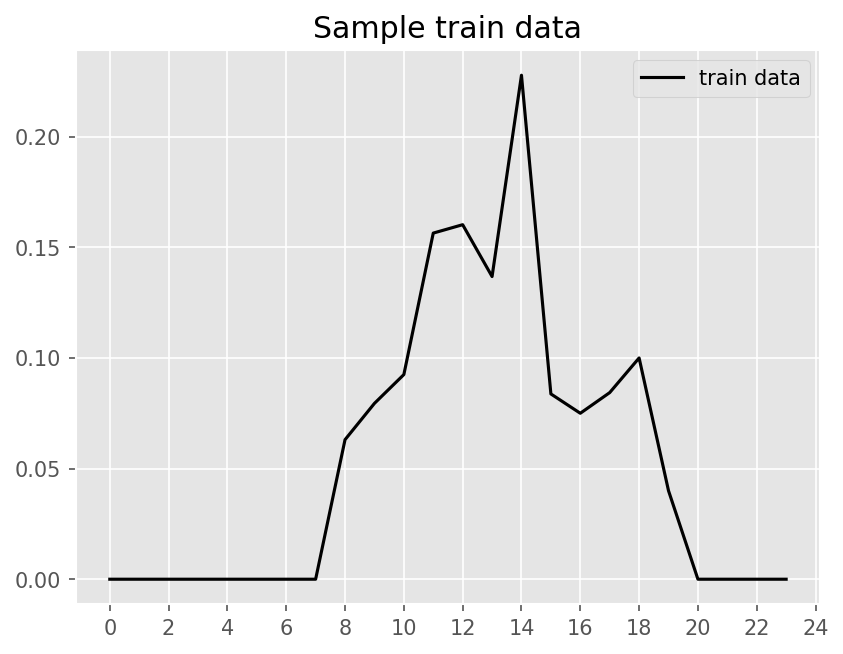

In [10]:
plt.style.use('ggplot')
plt.figure(dpi=150)
# 축 간격 설정
ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

# 그래프 그리기
y = train_x[0].cpu()
x = np.arange(len(train_x[0]))
plt.plot(x, y, color='black', label='train data')

plt.title("Sample train data")
plt.legend()         
plt.show()

In [11]:
class PyTorch_Model(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layers,batch_first=False):
        
        super(PyTorch_Model,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=False)
        self.fc1 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.drop1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.drop2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(hidden_size, output_size, bias=True)

    def forward(self, x):
        # Reshape Input Size for batch_first=True
        x = x.transpose(0, 1) # (B, L, I) -> (L, B, I)
    
        x, _status = self.rnn(x) # output x : (L, B, H)
        x = self.fc1(x) # (L, B, H) -> (L, B, H)
        x = self.drop1(x)
        x = self.fc2(x) # (L, B, H) -> (L, B, H)
        x = self.drop2(x)
        x = self.fc3(x) # (L, B, H) -> (L, B, O)
        
        # Reshape Output Size for batch_first=True
        x = x.transpose(0, 1) # (L, B, O) -> (B, L, O)
        return x

In [12]:
def train(model, optimizer, model_name="RNN_Model", verbose=True):
    print('Learning started. It takes sometime.')
    total_train_batch = len(train_x)
    total_valid_batch = len(valid_x)
    train_loss = []
    valid_loss = []
    
    for epoch in range(epochs):
        # Model training
        model.train()
        train_avg_cost = 0
        for idx, samples in enumerate(train_dataloader):
            x, y = samples
            hypothesis = model(x)
            cost = criterion(hypothesis, y)
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

            train_avg_cost += cost / total_train_batch
        train_loss.append(train_avg_cost)
            
        # Model validation
        model.eval()
        with torch.no_grad():
            valid_avg_cost = 0
            for idx, samples in enumerate(valid_dataloader):
                x, y = samples
                hypothesis = model(x)
                cost = criterion(hypothesis, y)

                valid_avg_cost += cost / total_valid_batch
            valid_loss.append(valid_avg_cost)
            
        if verbose:
            print('[Epoch:{:>2}] train_cost={:<21}, valid_cost={:<21}'.format(epoch + 1, train_avg_cost, valid_avg_cost))
                  
    print('Training Finished.')
    
    torch.save(model, f"model/{model_name}.pt")
    print('Model Saved.')
    
    train_loss = [l.detach().cpu() for l in train_loss]
    valid_loss = [l.cpu() for l in valid_loss]
    return train_loss, valid_loss

In [13]:
epochs = 100
learning_rate = 1e-3

input_size = 1
hidden_size = 128
output_size = 1
seq_len = 24
num_layers = 4

In [14]:
# Instantiate RNN model
given_model = PyTorch_Model(input_size, hidden_size, output_size, num_layers, batch_first=True).to(device)
print(given_model)

# Set loss and optimizer function
criterion = nn.L1Loss().to(device)
given_optimizer = optim.Adam(given_model.parameters(), lr=learning_rate)

PyTorch_Model(
  (rnn): RNN(1, 128, num_layers=4)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (drop1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (drop2): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)


In [15]:
given_train_loss, given_valid_loss = train(given_model, given_optimizer, model_name="PyTorch_Model")

Learning started. It takes sometime.
[Epoch: 1] train_cost=0.003556752810254693 , valid_cost=0.002870757132768631 
[Epoch: 2] train_cost=0.0025694542564451694, valid_cost=0.0023587611503899097
[Epoch: 3] train_cost=0.0020998171530663967, valid_cost=0.0022263771388679743
[Epoch: 4] train_cost=0.001964879222214222 , valid_cost=0.001856815768405795 
[Epoch: 5] train_cost=0.0019754222594201565, valid_cost=0.0020480917301028967
[Epoch: 6] train_cost=0.0019219279056414962, valid_cost=0.0019022732740268111
[Epoch: 7] train_cost=0.001794505282305181 , valid_cost=0.001799203222617507 
[Epoch: 8] train_cost=0.0017634318210184574, valid_cost=0.0016979321371763945
[Epoch: 9] train_cost=0.0017616485711187124, valid_cost=0.001740194857120514 
[Epoch:10] train_cost=0.0017531468765810132, valid_cost=0.0018781485268846154
[Epoch:11] train_cost=0.0017830306896939874, valid_cost=0.0017937221564352512
[Epoch:12] train_cost=0.0018040548311546445, valid_cost=0.001787621877156198 
[Epoch:13] train_cost=0.001

RuntimeError: Parent directory model does not exist.

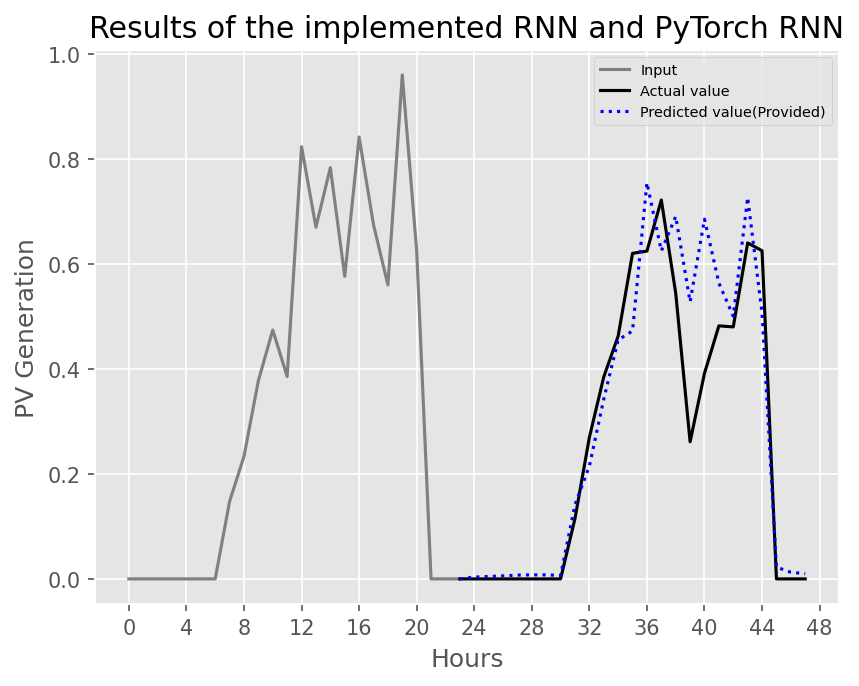

In [17]:
plt.style.use('ggplot')
plt.figure(dpi=150)
# 축 간격 설정
ax=plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))


# 입력 데이터 그래프 그리기 (Input)
input_y = test_x[0].cpu()
input_x = [i for i in range(len(input_y))]
plt.plot(input_x, input_y, color='gray', label='Input')

# 정답 데이터 그래프 그리기 (Actual value)
future = 24
answer_y = test_y[0].cpu()
answer_y = torch.cat([input_y[-1].view(-1, 1), answer_y], dim=0) # 직전 시간의 데이터와 연결해줌
answer_x = [future + i -1 for i in range(len(answer_y))]
plt.plot(answer_x, answer_y, color='black', label='Actual value')


# PyTorch_RNN 모델의 예측 그래프 그리기 (Predicted value(Implemented))
given_output_y = given_model(test_x[0].view([1, -1])).squeeze(0).to('cpu').detach()
given_output_y = torch.cat([input_y[-1], given_output_y], dim=0) # 직전 시간의 데이터와 연결해줌
given_output_x = [future + i -1 for i in range(len(given_output_y))]
plt.plot(given_output_x, given_output_y, color='blue', ls=":", label="Predicted value(Provided)")

plt.xlabel('Hours')
plt.ylabel('PV Generation')
plt.title("Results of the implemented RNN and PyTorch RNN")
plt.legend(fontsize="x-small", loc="upper right")
plt.show()